In [2]:
%matplotlib inline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from matplotlib.cm import *
from sklearn.naive_bayes import GaussianNB
import matplotlib.colors as colors
from numpy.ma import masked_array
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from mpl_toolkits.mplot3d import Axes3D

In [41]:
plt.rcParams['figure.figsize'] = (8,8)

In [37]:
def has_disease(d, positive_accuracy, negative_accuracy):
    return positive_accuracy * d / (positive_accuracy * d + (1 - negative_accuracy) * (1 - d))

In [35]:
def plot_disease(d, positive_accuracy = .98, negative_accuracy = .97):
    plt.plot(d, has_disease(d, positive_accuracy, negative_accuracy))
    plt.xlabel('Probability of disease')
    plt.ylabel('Probability of disease given positive result')
    plt.title('Test accuracy: positive %.2f, negative %.2f' % (positive_accuracy, negative_accuracy))

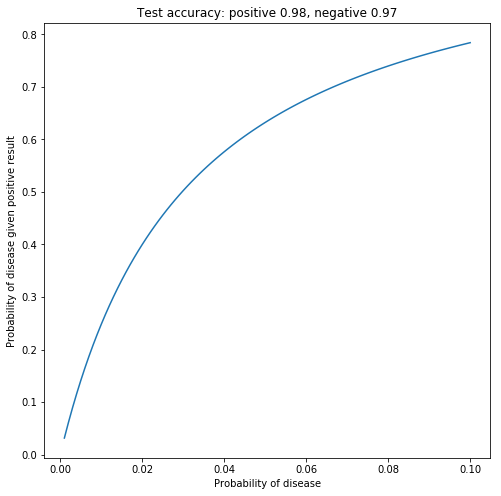

In [42]:
plot_disease(np.linspace(0.001, 0.1, 100), 
             positive_accuracy = .98, 
             negative_accuracy = .97)

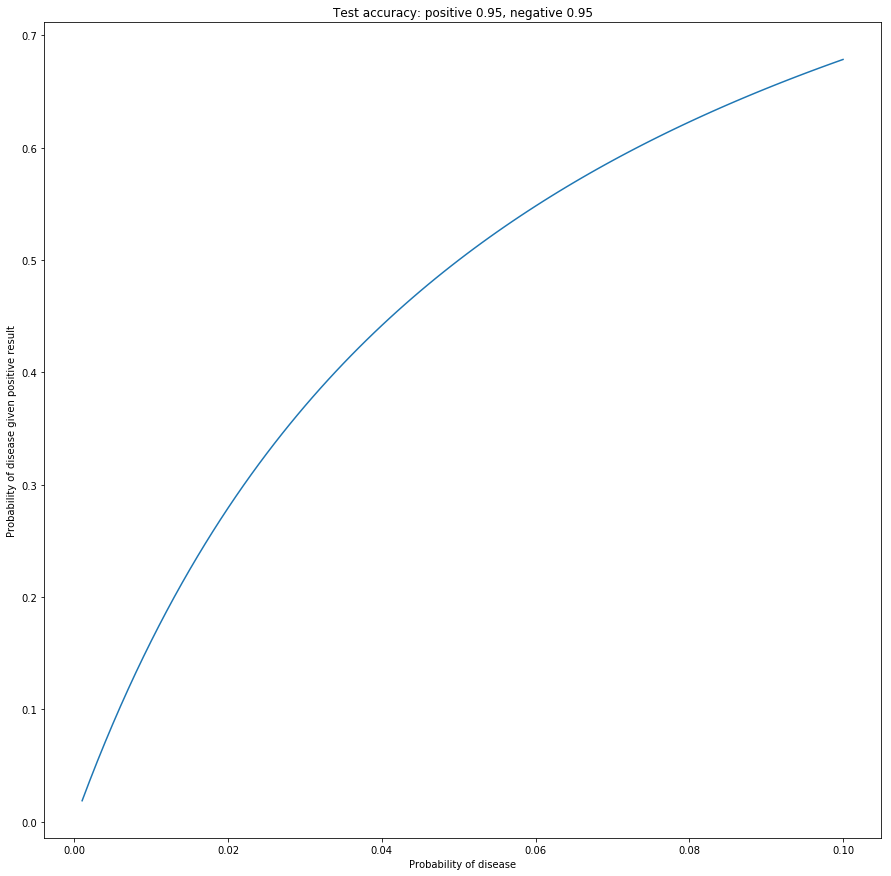

In [40]:
plot_disease(np.linspace(0.001, 0.1, 100), 
             positive_accuracy = .95, 
             negative_accuracy = .95)

In [54]:
x,q = np.array([1,3,6,10,11,13]), np.array([1,0,5,2,1,4])

In [56]:
mean_squared_error(q, x / 2)

5.833333333333333

In [58]:
mean_squared_error(q, np.ones_like(x) * 2)

3.1666666666666665

In [60]:
mean_squared_error(q, x % 9)

2.0

In [67]:
reg = LinearRegression()
reg.fit(x.reshape(-1,1),q.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [69]:
reg.coef_, reg.intercept_

(array([[ 0.16470588]]), array([ 0.95882353]))

In [74]:
mean_squared_error(q, reg.predict(x.reshape(-1,1)))

2.6264705882352941

## gaussian naive bayes classification

In [6]:
X = np.array([[-1, 0], [-2, -0.5], [-3, -2], [1, 1], [2, 1], [3, 2], [0,0], [3,2], [3,2], [3,2], [3,2]])
y = np.array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2])
clf = GaussianNB()
clf.fit(X, y)

def stats(clf, X, y):
    print 'Class prior:\n', clf.class_prior_
    print 'Theta:\n',clf.theta_
    print 'Sigma:\n',clf.sigma_
    uniq_y = np.unique(y)
    for yy in uniq_y:
        print 'Mean y=%d' % yy, np.mean(X[y == yy], axis = 0)
    for yy in uniq_y:        
        print 'Variance y=%d' % yy, np.var(X[y == yy], axis = 0)

In [7]:
def pde(X, x):
    s2 = np.var(X, axis = 0)
    s2[s2  == 0 ] = 1e-9
    m = np.mean(X, axis = 0)
    return 1.0/np.sqrt(2 * np.pi * s2) * np.exp(-0.5*(x - m)**2 / s2)

In [ ]:
stats(clf, X , y)

In [15]:
def plot_class_probability(X, y, xx1, xx2, cmaps, f, subplot):
    for idx, yy in enumerate(np.unique(y)):
        plt.subplot(subplot + idx)
        plt.title('P(X|y=%d)P(y=%d)' % (yy, yy))
        XX = X[y == yy]
        Z = pde(XX, np.c_[xx1.ravel(), xx2.ravel()])
        ZZ = Z[:,0] * Z[:,1]
        ZZ = ZZ.reshape(xx1.shape)
        py = 1.0*len(y[y == yy]) / len(y)
        ZZ = ZZ * py
        plt.pcolormesh(xx1, xx2, ZZ, cmap=cmaps[idx], alpha = 1, antialiased = True)
        #plt.contourf(xx1, xx2, ZZ, cmap=cmaps[idx])        
        plt.scatter(XX[:,0], XX[:,1], marker='x', c='black', label='Class %d' % yy)
        
        ax = f.add_subplot(subplot + 4 + idx, projection='3d')
        ax.plot_surface(xx1, xx2, ZZ, cmap=cmaps[idx])

In [10]:
def plot_all_classes_probabilities(X, y, xx1, xx2, cmaps, f, subplot):    
    plt.subplot(subplot)       
    plt.title('P(X|y=1)P(y=1) vs \nP(X|y=2)P(y=2)    ')
    py = 1.0 * len(y[y == 1]) / len(y)
    Z = pde(X[y == 1], np.c_[xx1.ravel(), xx2.ravel()]) 
    Z = Z[:,0] * Z[:,1] * py
    Z1 = Z.reshape(xx1.shape)    
    py = 1.0*len(y[y == 2]) / len(y)
    Z = pde(X[y == 2], np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z[:,0] * Z[:,1] * py
    Z2 = Z.reshape(xx1.shape)
    Z1 = masked_array(Z1, Z1 < Z2)
    Z2 = masked_array(Z2, Z2 < Z1)    
    plt.pcolormesh(xx1, xx2, Z1, cmap=cmaps[0], alpha = 1.0, antialiased = True)
    plt.pcolormesh(xx1, xx2, Z2, cmap=cmaps[1], alpha = 1.0, antialiased = True)

    ax = f.add_subplot(subplot + 4, projection='3d')
    zxx1, zxx2 = np.copy(xx1), np.copy(xx2)
    zxx1[Z1 < Z2], zxx2[Z1 < Z2] = 0, 0        
    ax.plot_surface(zxx1, zxx2, Z1, cmap=cmaps[0])
    zxx1, zxx2 = np.copy(xx1), np.copy(xx2)
    zxx1[Z1 > Z2], zxx2[Z1 > Z2] = 0, 0        
    ax.plot_surface(zxx1, zxx2, Z2, cmap=cmaps[1])

In [11]:
def plot_classifier(clf, xx1, xx2, cmap, name):
    plt.title('clf %s' % name)
    Z = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    plt.pcolormesh(xx1, xx2, Z, cmap = cmap, antialiased = True)
    plt.legend(loc = 'upper left')

In [12]:
def plot_data(X, y, cmap):
    for idx,yy in enumerate(np.unique(y)):
        xx = X[y == yy]
        c = cmap(idx)        
        plt.scatter(xx[:,0], xx[:,1], c = c, marker = 'X', label='class %d' % yy)
        plt.legend()
        plt.title('Data with %d classes' % len(np.unique(y)))

In [13]:
def plot_probability(X, y):
    x1_min, x2_min = np.min(X, axis = 0) - 1
    x1_max, x2_max = np.max(X, axis = 0) + 1
    x1_step, x2_step = np.ptp(X, axis = 0) / 100.0
    cmaps = [coolwarm, PiYG]
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, x1_step), np.arange(x2_min, x2_max, x2_step))
    f = plt.figure(figsize=(17,7))
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    subplot = 241;
    plot_class_probability(X, y, xx1, xx2, cmaps, f, subplot)
    plot_all_classes_probabilities(X, y, xx1, xx2, cmaps, f, subplot + 2)
    
    cmaps2 = colors.LinearSegmentedColormap.from_list('my', [cmap(1.0) for cmap in cmaps], N = 2)
    clf = GaussianNB()
    clf.fit(X, y)
    plt.subplot(subplot + 3)
    plot_classifier(clf, xx1, xx2, cmaps2, 'GaussianNB')
    
    #plt.subplot(subplot + 7)
    #plot_data(X, y, cmaps2)
    
#     clf = DecisionTreeClassifier()
#     #clf = NearestCentroid()
#     clf.fit(X, y)
#     plt.subplot(subplot + 4)
#     plot_classifier(clf, xx1, xx2, cmaps, 'DecisionTree')
    
#     for idx, C in enumerate([1, 10, 100, 1000]):
#         clf = SVC(kernel='rbf', C=C, gamma=C)
#         clf.fit(X, y)
#         plt.subplot(subplot + 5 + idx)
#         plot_classifier(clf, xx1, xx2, cmaps, 'SVC(C=%d, g=%d)' % (C, C))

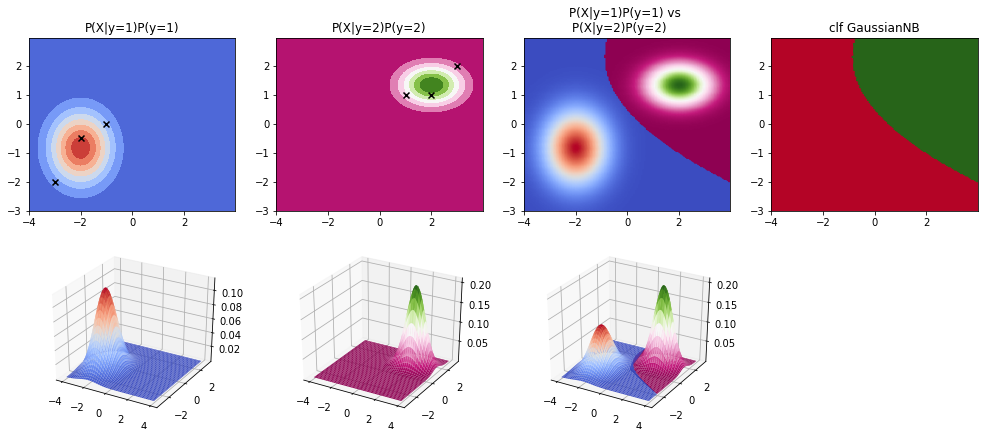

In [16]:
X = np.array([[-1, 0], [-2, -0.5], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])
plot_probability(X, y)

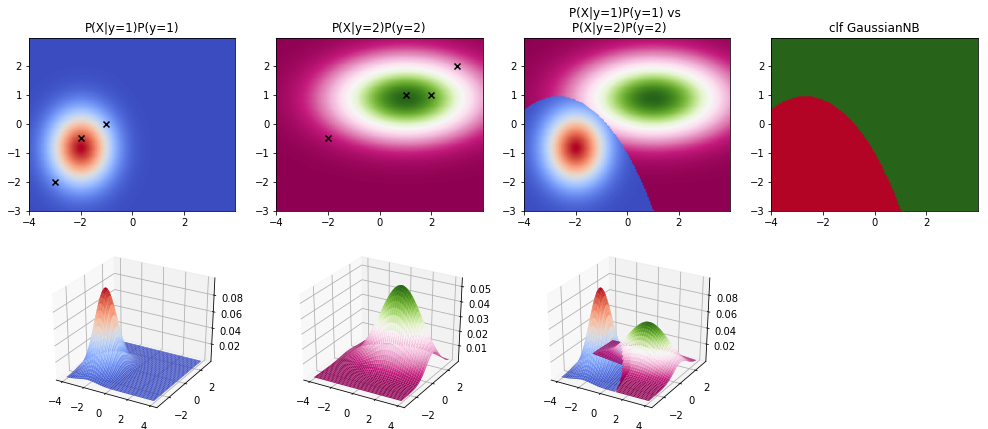

In [531]:
X = np.array([[-1, 0], [-2, -0.5], [-3, -2], [1, 1], [2, 1], [3, 2], [-2, -0.5]])
y = np.array([1, 1, 1, 2, 2, 2, 2])
plot_probability(X, y)

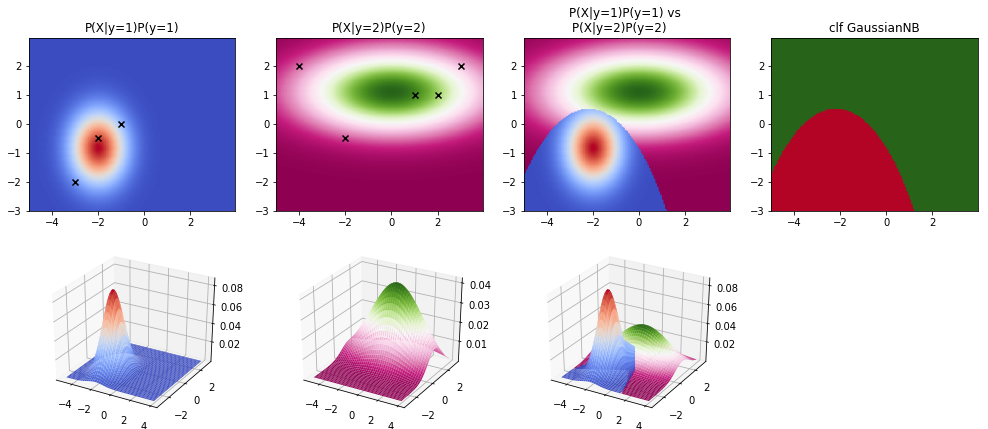

In [532]:
X = np.array([[-1, 0], [-2, -0.5], [-3, -2], [1, 1], [2, 1], [3, 2], [-2, -0.5], [-4, 2]])
y = np.array([1, 1, 1, 2, 2, 2, 2, 2])
plot_probability(X, y)

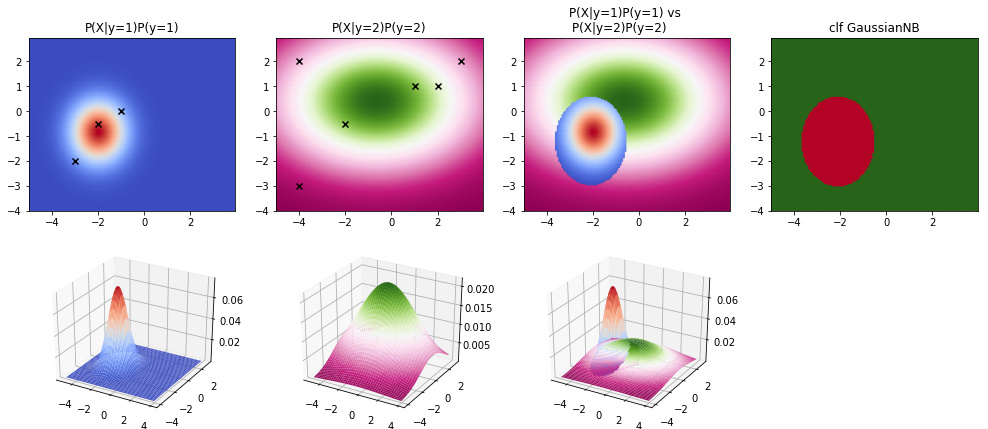

In [533]:
X = np.array([[-1, 0],[-2, -0.5],[-3, -2],[1, 1],[2, 1],[3, 2],[-2, -0.5],[-4, 2],[-4, -3]])
y = np.array([1, 1, 1, 2, 2, 2, 2, 2, 2])
plot_probability(X, y)

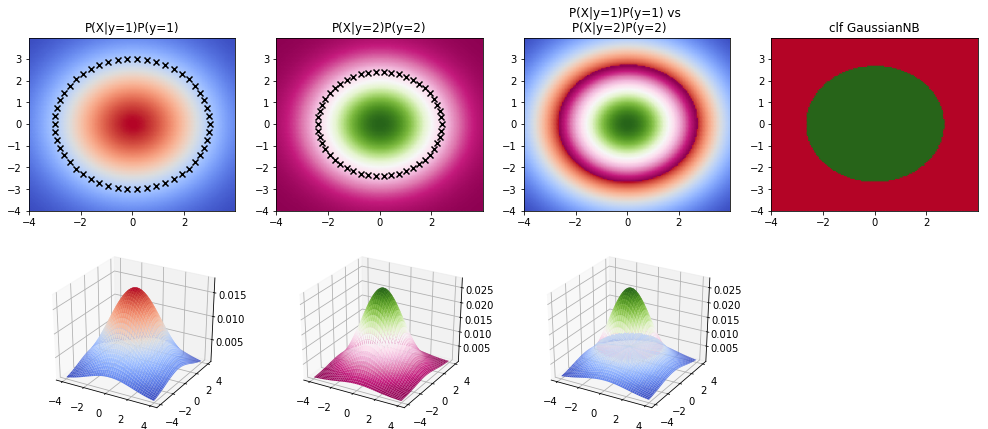

In [534]:
X, y = make_circles(random_state=42)
plot_probability(X * 3, y + 1)

### Bayes mini-project

In [26]:
s = 'So if you could just go ahead and pack up your stuff and move it down there, that would be terrific, OK?'

#### Probability of 'you', 'if', 'you' after 'if'

In [25]:
ss = s.replace(',', '').replace('?', '').lower().split()

print 1.0 * ss.count('if') / len(ss)
print 1.0 * ss.count('you') / len(ss)


0.0454545454545
0.0454545454545
